# MUTCD Sign Classification

This notebook performs transfer learning using Pytorch's [torchvision models](https://pytorch.org/vision/stable/models.html) to classify traffic signs according to their MUTCD category. The MUTCD categories have three broad categores [guide](https://mutcd.fhwa.dot.gov/SHSe/Guide.pdf), [regulatory](https://mutcd.fhwa.dot.gov/SHSe/Regulatory.pdf), and [warning](https://mutcd.fhwa.dot.gov/SHSe/Warning.pdf). Contained in these three broad categories, there are over **600** different categories of signs. In this notebook we attempt to perform classification of signs into those categories.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
import json

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.functional as F

In [3]:
from signutils.data import create_image_dataframe
from signutils.data import SyntheticSignData, MakeSquare, RotateImage, ResizeImage, ToTensor, NormalizeImage, UnNormalizeImage
from signutils.train import train_model, format_training_records
from signutils.models import load_pretrained_model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device {device}")

Using Device cuda


## Read Image Information Dataframe

In [5]:
with open('label_encoder.json') as fl:
    label_encoder = json.loads(json.load(fl))
label_decoder = {label_encoder[key]: key for key in label_encoder.keys()}

In [6]:
df = pd.read_csv('classification_train.csv')
df_test = pd.read_csv('classification_test.csv')

df.head()

,path,labelname,filename,label
0,../Synthetic/basic_classification/w4-1l/453_33...,w4-1l,453_33_W_w4-1l.jpg,544
1,../Synthetic/basic_classification/w4-1l/453_19...,w4-1l,453_195_W_w4-1l.jpg,544
2,../Synthetic/basic_classification/w4-1l/453_62...,w4-1l,453_62_W_w4-1l.jpg,544
3,../Synthetic/basic_classification/w4-1l/453_11...,w4-1l,453_118_W_w4-1l.jpg,544
4,../Synthetic/basic_classification/w4-1l/453_14...,w4-1l,453_143_W_w4-1l.jpg,544


## Format data into train and validation datasets
### Perform the train validation split

In [7]:
# set the amount of the data to be included in the training dataset
split = 7/10
total_samples = len(df)
split_idx = int(np.floor(total_samples * split))

index = np.arange(total_samples)
np.random.seed(123)
np.random.shuffle(index)

train_idx, val_idx = index[:split_idx], index[split_idx:]

print("Data Split")
print(f"Number of training images:   {len(train_idx)}")
print(f"Number of validation images: {len(val_idx)}")

Data Split
Number of training images:   270519
Number of validation images: 115938


### Create Datasets

In [8]:
# standar values for normalization using pytorch pre-trained models
norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# create training dataset
dataset_train = SyntheticSignData(df.iloc[train_idx, :], transform=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    RotateImage(p=0.5, degrees=20),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
]))

# create validation dataset
dataset_val = SyntheticSignData(df.iloc[val_idx, :], transform=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
]))

# create test dataset
dataset_test = SyntheticSignData(df_test, transform=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
]))

# create dictionary of dataset length (for use in training)
dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_val)}
unnormalize_image = UnNormalizeImage(mean=norm_mean, std=norm_std)

In [9]:
# create transform to transform images from outside the datasets
transform_in=transforms.Compose([
    MakeSquare(),
    ResizeImage((64, 64)),
    ToTensor(),
    NormalizeImage(norm_mean, norm_std)
])

### Visualize image from dataset

Total Images: 270519


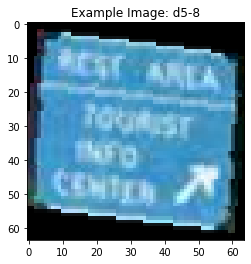

In [11]:
# select random image
idx = np.random.randint(len(dataset_train))
image, label = dataset_train[idx]
# format image to be visualized
im = image.clone().to(device='cpu').detach()
im = unnormalize_image(im).transpose((1, 2, 0))

print(f"Total Images: {len(dataset_train)}")

# display image
plt.imshow(im)
plt.title(f"Example Image: {label_decoder[int(label)]}")
plt.show()

## Create DataLoaders

In [12]:
# set batch size
batch_size=256

# create data loaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# create dictionary of dataloaders for training
dataloaders = {'train': dataloader_train, 'val': dataloader_val}

## Set Modeling Parameters
### Select model and change the final fully connected layer

In [13]:
# get the number of classes in dataset
out_ftrs = len(np.unique(dataset_train.labels))

# load model with adjusted final layer to reflect the number of classes
model = load_pretrained_model('efficientnet_b0', out_ftrs)
model = model.to(device=device)

In [14]:
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## Train the Model

In [13]:
num_epochs=10

model, loss_record, acc_record = train_model(model, 
                                             criterion, 
                                             optimizer,
                                             dataloaders=dataloaders,
                                             dataset_sizes=dataset_sizes,
                                             device=device,
                                             num_epochs=num_epochs, 
                                             scheduler=None, 
                                             print_every=100)

out_name = f"trial-{model.__class__.__name__}-{num_epochs}-{optimizer.__class__.__name__}-{str(lr).split('.')[-1]}-0"

Epoch 0/9
----------------------------------------------------------------------
Batch: 0000, loss: 6.47612 time: 0.001
Batch: 0100, loss: 0.95149 time: 0.009
Batch: 0200, loss: 0.33391 time: 0.017
Batch: 0300, loss: 0.15517 time: 0.026
Batch: 0400, loss: 0.22608 time: 0.037
Batch: 0500, loss: 0.13018 time: 0.045
Batch: 0600, loss: 0.10354 time: 0.056
Batch: 0700, loss: 0.10570 time: 0.065
Batch: 0800, loss: 0.07697 time: 0.075
Batch: 0900, loss: 0.08836 time: 0.086
Batch: 1000, loss: 0.06780 time: 0.095
Epoch: 0000, Phase: train, Loss: 0.44036, Acc: 0.89420, Time: 0.100
Epoch: 0000, Phase: val  , Loss: 0.05831, Acc: 0.98295, Time: 0.142

Epoch 1/9
----------------------------------------------------------------------
Batch: 0000, loss: 0.12862 time: 0.142
Batch: 0100, loss: 0.07339 time: 0.151
Batch: 0200, loss: 0.03777 time: 0.161
Batch: 0300, loss: 0.02461 time: 0.172
Batch: 0400, loss: 0.07010 time: 0.180
Batch: 0500, loss: 0.02869 time: 0.191
Batch: 0600, loss: 0.05711 time: 0.200

## Save Training Results

In [15]:
# make results folder
results_path = os.path.join('training_results', out_name)
if not os.path.isdir(results_path):
    os.mkdir(results_path)

# format loss and accuracy
df_loss_epoch, df_loss_batch, df_acc = format_training_records(loss_record=loss_record, acc_record=acc_record)

# save model weights
torch.save(model.state_dict(), os.path.join(results_path, "model_weights.pth"))
# save entire model
torch.save(model, os.path.join(results_path, "model_entire.pth"))

# save label encoder
json_encoder = json.dumps(label_encoder)     
with open(os.path.join(results_path, "encoder.json"), "w") as outfile:
    json.dump(json_encoder, outfile)

# save training results
df_loss_epoch.to_csv(os.path.join(results_path, "loss_epoch.csv"), index=False)
df_loss_batch.to_csv(os.path.join(results_path, "loss_batch.csv"), index=False)
df_acc.to_csv(os.path.join(results_path, "accuracy.csv"), index=False)

## Review Model
### Review loss and accuracy curves

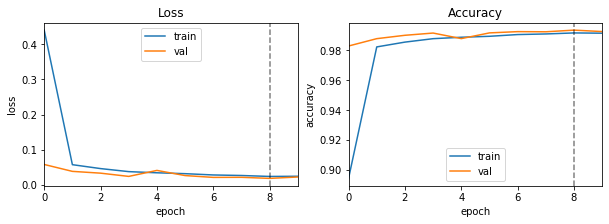

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
df_loss_epoch.plot(ax=ax[0])
df_acc.plot(ax=ax[1])

best_epoch = df_acc['val'].values.argmax()

for i, lab in enumerate(['loss', 'accuracy']):
    ax[i].set_ylabel(lab)
    ax[i].set_title(lab.capitalize())
    ax[i].set_xlabel('epoch')
    ax[i].axvline(x=best_epoch, c='k', ls='--', alpha=0.5)
    
plt.show()

## Review Multiple Model's Results

In [15]:
results = sorted(glob('./training_results/trial-EfficientNet-10-Adam*')) # trial 0 (1)
results

['./training_results/trial-EfficientNet-10-Adam-001-0',
 './training_results/trial-EfficientNet-10-Adam-001-1',
 './training_results/trial-EfficientNet-10-Adam-001-2']

### Review Training Records

In [16]:
df_results=[]
for i, fldr in enumerate(results):
    
    temp = pd.read_csv(os.path.join(fldr, 'accuracy.csv'))
    temp['trial'] = i
    
    df_results.append(temp)
    
df_results = pd.concat(df_results)
df_results.reset_index(inplace=True)
df_results.columns = ['Epoch', 'Training', 'Validation', 'trial']

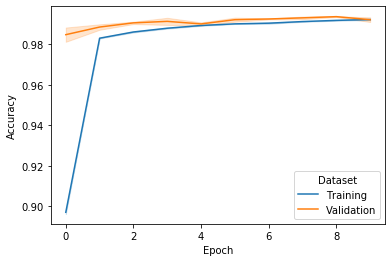

In [17]:
df_results_melt = df_results.melt(id_vars=['Epoch', 'trial'])
df_results_melt.columns = ['Epoch', 'trial', 'Dataset', 'Accuracy']

sns.lineplot(data=df_results_melt, x='Epoch', y='Accuracy', hue='Dataset', ci='sd')
plt.show()

### Review Accuray On Hold Out Test Data

In [18]:
def get_top_k_accuracy(predictions, labels, k=5):
    
    pred_val, pred_idx = predictions.sort(dim=1, descending=True)
    
    top_k=[]
    for i in range(len(labels)):
        top_k.append(labels[i] in pred_idx[i, :k])
        
    top_k = torch.tensor(top_k)
    acc = top_k.sum() / len(top_k)
    
    return acc.item(), top_k

In [19]:
for i, fldr in enumerate(results):
    model = torch.load(os.path.join(fldr, 'model_entire.pth'))
    
    model = model.to(device=device)
    model.eval()
    total_correct=0
    pred_all=[]
    y_all=[]
    for b in dataloader_test:
        X, y = b
        X = X.to(device=device)
        y = y.to(device=device)
        with torch.no_grad():
            pred = model(X)
        pred_all.append(pred.clone())
        y_all.append(y)

    pred_all = torch.concat(pred_all)
    y_all = torch.concat(y_all)
    
    accuracies=[]
    k_values = np.arange(1, 51)
    for k in k_values:
        acc, topk = get_top_k_accuracy(pred_all, y_all, k=k)
        accuracies.append(acc)
    accuracies = np.array(accuracies)
    
    df_test_acc = pd.DataFrame({'Accuracy': accuracies, 'k': k_values})
#     df_test_acc.to_csv(os.path.join(fldr, 'accuracy_k_test.csv'), index=False)

In [20]:
df_results_test=[]
for i, fldr in enumerate(results):
    
    temp = pd.read_csv(os.path.join(fldr, 'accuracy_k_test.csv'))
    temp['trial'] = i
    
    df_results_test.append(temp)
    
df_results_test = pd.concat(df_results_test)
df_results_test.reset_index(inplace=True, drop=True)

In [21]:
df_acc_bar = df_results[df_results['Epoch']==9].reset_index(drop=True).drop('Epoch', axis=1)
df_acc_bar['Test'] = df_results_test[df_results_test['k']==1]['Accuracy'].values
df_acc_bar = df_acc_bar.melt(id_vars='trial')
df_acc_bar.columns=['trial', 'Dataset', 'Accuracy']
df_acc_bar

,trial,Dataset,Accuracy
0,0,Training,0.992067
1,1,Training,0.992052
2,2,Training,0.992511
3,0,Validation,0.993410
4,1,Validation,0.991168
5,2,Validation,0.991823
6,0,Test,0.473282
7,1,Test,0.488550
8,2,Test,0.454198


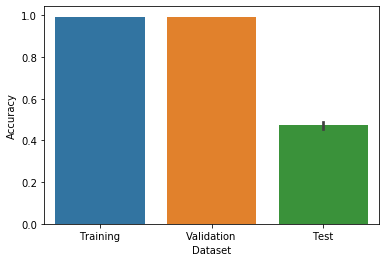

In [22]:
sns.barplot(data=df_acc_bar, x='Dataset', y='Accuracy')

### Review Accuray On Hold Out Test Data (top k predictions)

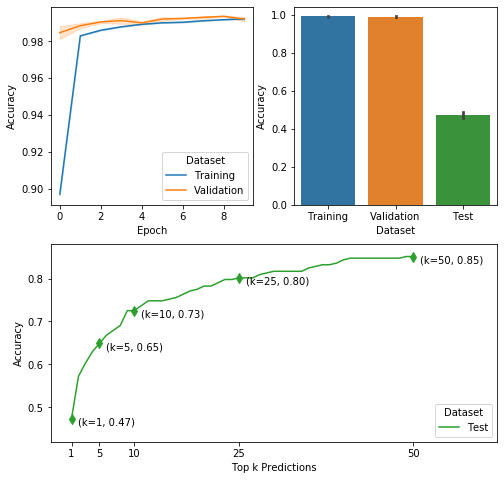

In [29]:
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.lineplot(data=df_results_melt, x='Epoch', y='Accuracy', hue='Dataset', ci='sd', ax=ax1)
sns.barplot(data=df_acc_bar, x='Dataset', y='Accuracy', ci='sd', ax=ax2)

t=0
accuracies = df_results_test[df_results_test['trial']==t]['Accuracy'].values
k_values = df_results_test[df_results_test['trial']==t]['k'].values

pnts = [1, 5, 10, 25, 50]
ax3.plot(k_values, accuracies, c='tab:green', label='Test')
pnts = np.array(pnts) - 1
k_sub, acc_sub = k_values[pnts], accuracies[pnts]
ax3.scatter(k_sub, acc_sub, marker='d', s=50, c='tab:green')
text = [f"(k={k_values[idx]}, {accuracies[idx]:.2f})" for idx in pnts]
for idx in range(len(pnts)):
    ax3.text(k_sub[idx]+1, acc_sub[idx]-0.015, text[idx])
    
ax3.set_xlim(-2, 62)
ax3.set_ylim(0.42, 0.88)
ax3.set_xticks(pnts+1)
ax3.set_xlabel('Top k Predictions')
ax3.set_ylabel('Accuracy')
ax3.legend(loc='lower right', title='Dataset')

fig.tight_layout
# plt.savefig('./Synthetic/basic_classification_results/plots/classification_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

### Review Saliency Maps

In [24]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    # Make input tensor require gradient
    X.requires_grad_()

    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                    #
    ##############################################################################
    # Replace "pass" statement with your code

    # forward pass
    scores = model(X)

    # encode correct scores
    y_encode = torch.zeros_like(scores)
    y_encode[torch.arange(y.shape[0]), y]=1

    # get correct scores
    correct_scores = y_encode * scores

    # sum into loss
    loss = correct_scores.sum()

    # backward pass
    loss.backward()

    # compute saliencey  
    saliency = X.grad # get gradient
    saliency = saliency.abs() # take absolute value
    saliency, indices = torch.max(saliency, dim=1) # https://pytorch.org/docs/stable/generated/torch.max.html

    ##############################################################################
    #               END OF YOUR CODE                 #
    ##############################################################################
    return saliency

In [26]:
model = torch.load('./training_results/trial-EfficientNet-10-Adam-001-0/model_entire.pth')

In [27]:
for b in dataloader_train:
    break
X, y = b

X = X.to(device=device)
y = y.to(device=device)
model = model.to(device=device)

saliency = compute_saliency_maps(X, y, model)

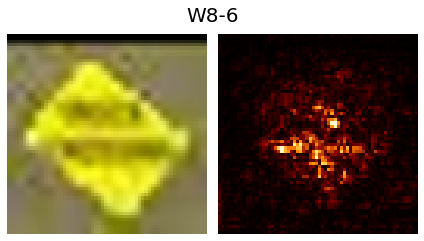

In [36]:
sm_dir = './Synthetic/saliency-maps'

cmap='afmhot'

idx=np.random.randint(len(X))

x_show = X[idx].clone()
x_show = unnormalize_image(x_show.clone().detach().to(device='cpu')).transpose((1, 2, 0))
s_show = saliency[idx].clone().detach().cpu()


fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(x_show)
ax[1].imshow(s_show, cmap=cmap)

fig.suptitle(f'{label_decoder[y[idx].item()].upper()}', y=0.94, fontsize=20)
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()